# Example of a coordinate transformation from z levels to density levels

### Rebinning `ty_trans` to `ty_trans_rho` density levels

This transformation is commonly used for the purpose of decomposing the residual meridional overturning streamfunction into mean and eddy components. The mean is taken to be the time-mean Eulerian transport (time-mean in z coordinates), whilst the residual transport is the time-mean in density coordinates (density surface move in time). The eddy transport is the difference between the residual overturnng streamfunction, and the Eulerian transport **transformed from depth to density coordinates** via the time-mean density.

Binning is the discrete version of this transformation from depth to density coordinates. We define target density bins, and for each bin we add the quantity to be binned from all cells with a density that satisfies that bin. In its simplest form, binning is creating a histogram.

We will use two different binning methods:
1. `xgcm` conservative binning (define edge of bins)
2. Using density coordinate binning method of Lee et al. (2007) (define isopycnals to bin onto i.e. centre)

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
from gsw import SA_from_SP, p_from_z, sigma1, CT_from_t, sigma0, sigma4
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import cartopy.crs as ccrs

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39689/status,
Dashboard: /proxy/39689/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43005,Workers: 4
Dashboard: /proxy/39689/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:42815,Total threads: 4
Dashboard: /proxy/36527/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:37853,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

# reference density value:
rho_0 = 1035.0
g = 9.81

# reduce computation by choosing only Southern Ocean latitudes
lat_range = slice(-70,-34.99)

### Step 1: Load density and quantity being binned 
(you can choose any other quantity instead of `ty_trans`, e.g. `dzt`, but if it is not on t-grid then interpolate it to t-grid)

#### We will load one year of monthly `ty_trans`, `ty_trans_rho` and `pot_rho_2`

Then take weighted time average

In [4]:
start_time = '2170-01-01'
end_time = '2170-12-31'
time_slice = slice(start_time, end_time)

In [5]:
%%time
ty_trans = cc.querying.getvar(expt,'ty_trans', session, start_time = start_time, end_time = end_time)
ty_trans = ty_trans.sel(time = time_slice).sel(yu_ocean = lat_range)
# weighed time mean by month length
month_length = ty_trans.time.dt.days_in_month
ty_trans = (ty_trans*month_length).sum('time')/365


CPU times: user 2.35 s, sys: 952 ms, total: 3.3 s
Wall time: 11.8 s


In [6]:
%%time
pot_rho_2 = cc.querying.getvar(expt,'pot_rho_2', session, start_time = start_time, end_time = end_time)
pot_rho_2 = pot_rho_2.sel(time = time_slice).sel(yt_ocean = lat_range)
pot_rho_2 = (pot_rho_2*month_length).sum('time')/365


CPU times: user 409 ms, sys: 142 ms, total: 550 ms
Wall time: 1.58 s


In [7]:
%%time
ty_trans_rho = cc.querying.getvar(expt,'ty_trans_rho', session, start_time = start_time, end_time = end_time)
ty_trans_rho = ty_trans_rho.sel(time = time_slice).sel(grid_yu_ocean = lat_range)
ty_trans_rho = (ty_trans_rho*month_length).sum('time')/365


CPU times: user 566 ms, sys: 126 ms, total: 692 ms
Wall time: 1.32 s


In [8]:
# interpolate ty_trans to t grid (where density is)
ty_trans = ty_trans.interp({'yu_ocean':pot_rho_2.yt_ocean})

# Method 1: `xgcm`

Use `xgcm` conservative binning, described in the tutorial available at: https://xgcm.readthedocs.io/en/latest/transform.html

The computation is robust to different selections of density bins, but currently has issues with partial cells in MOM5. We thus add a correction after the computation to account for partial cells.

### Load vertical grid bin centres and edges

In [9]:
%%time

st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)
st_edges_ocean = cc.querying.getvar(expt,'st_edges_ocean',session,n=1)

CPU times: user 2.48 s, sys: 742 ms, total: 3.22 s
Wall time: 7.46 s


### define *EDGE* of target density bins

Output will be an array with coordinate density the linear centre of these bins. If we choose potrho_edges, the end result will have coordinates potrho, which is the same as online binned ty_trans_rho.

In [10]:
pot_rho_2_target = cc.querying.getvar(expt,'potrho_edges', session, start_time = start_time, end_time = end_time, n=1,frequency = '1 monthly' ).values


### and get rid of NaNs

In [11]:
ty_trans = ty_trans.fillna(0)
pot_rho_2 = pot_rho_2.fillna(0)

### load first to reduce computation time

In [12]:
%%time
pot_rho_2 = pot_rho_2.load()
ty_trans = ty_trans.load()

CPU times: user 1min 2s, sys: 12.2 s, total: 1min 14s
Wall time: 1min 50s


### calculate vertical regridding into density coordinates

In [13]:
%%time

ds = xr.Dataset({'ty_trans':ty_trans,'pot_rho_2':pot_rho_2}) 
#Note if not using ty_trans, quantity must be extensive e.g.vhrho_nt, uhrho_et, tx_trans (counterexample: v, salt). 
#If not extensive, multiply by dzt or dzu.
ds = ds.assign_coords({'st_edges_ocean':st_edges_ocean})
ds = ds.chunk({'st_edges_ocean':76,'st_ocean':75}) #xgcm doesn't like it if there is more than 1 chunk in this axis
grid = xgcm.Grid(ds, coords={'Z':{'center':'st_ocean','outer':'st_edges_ocean'}},periodic = False)
ds['pot_rho_2_outer'] = grid.interp(ds.pot_rho_2, 'Z', boundary='extend')
ds['pot_rho_2_outer'] = ds['pot_rho_2_outer'].chunk({'st_edges_ocean':76})

ty_trans_transformed_cons = grid.transform(ds.ty_trans,
                                  'Z',
                                  pot_rho_2_target,
                                  method='conservative',
                                  target_data=ds.pot_rho_2_outer)
### change name to fit previous bins because default xgcm naming is different
#pot_rho_2_outer is actually the CENTRE of bins (I guess the convention was defined for linear interpolation not conservative)
ty_trans_transformed_cons = ty_trans_transformed_cons.rename({'pot_rho_2_outer':'potrho'})



CPU times: user 601 ms, sys: 10.2 ms, total: 612 ms
Wall time: 580 ms


In [14]:
%%time
ty_trans_transformed_cons = ty_trans_transformed_cons.load()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 8.56 GiB -- Worker memory limit: 11.23 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 8.56 GiB -- Worker memory limit: 11.23 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 8.56 GiB -- Worker memory limit: 11.23 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; s

CPU times: user 12.2 s, sys: 6.06 s, total: 18.3 s
Wall time: 1min 26s


#### Now account for partial cell at bottom
We do this by finding what is missing from the vertical integral (residual). This is what was in the partial cell. We then add that residual into the densest cell that currently exists in the transformed data. This is only an approximation, because the density of the partial cell may be denser than that of the cell above it. However, this correction means the vertical integral is preserved under the transformation.

In [15]:
%%time
#find residual from vertical integral
ty_trans_residual = ty_trans.sum('st_ocean')-ty_trans_transformed_cons.sum('potrho') #this is positive definite

CPU times: user 1.5 s, sys: 700 ms, total: 2.2 s
Wall time: 2.05 s


#### Find bottom density of `ty_trans_transformed_cons`

In [16]:
%%time
# select out bottom values:
ty_trans_transformed_cons2 = ty_trans_transformed_cons.where(ty_trans_transformed_cons!=0) 
dens_array = ty_trans_transformed_cons2 * 0 + ty_trans_transformed_cons2.potrho # array of isopycnal value where it exists and nan elsewhere
max_dens = dens_array.max(dim = 'potrho', skipna= True)

CPU times: user 1.46 s, sys: 996 ms, total: 2.46 s
Wall time: 2.29 s


#### Add residual to this bottom density in array

In [17]:
%%time
ty_trans_residual_array = (dens_array.where(dens_array == max_dens)*0+1)*ty_trans_residual
ty_trans_new = ty_trans_residual_array.fillna(0)+ ty_trans_transformed_cons

CPU times: user 2.63 s, sys: 1.9 s, total: 4.53 s
Wall time: 4.24 s


In [18]:
# interpolate back to the ty_trans_rho array, so that these variables can be added or subtracted.
ty_trans_new = ty_trans_new.interp({'yt_ocean':ty_trans_rho.grid_yu_ocean,'xt_ocean':ty_trans_rho.grid_xt_ocean})

In [19]:
%%time

ty_trans_new = ty_trans_new.load()

CPU times: user 599 µs, sys: 0 ns, total: 599 µs
Wall time: 628 µs


#### Plot streamfunction of result

In [20]:
def cumsum_from_bottom (residual):
    cumsum= (residual.cumsum('potrho')-residual.sum('potrho'))
    return cumsum

In [21]:
psi_avg = cumsum_from_bottom(ty_trans_rho.sum('grid_xt_ocean')/1e6/rho_0)
psi_avg_mean = cumsum_from_bottom(ty_trans_new.fillna(0).sum('grid_xt_ocean')/1e6/rho_0)

CPU times: user 1min 9s, sys: 5.85 s, total: 1min 15s
Wall time: 1min 37s


Text(0.5, 1.0, 'Eddy')

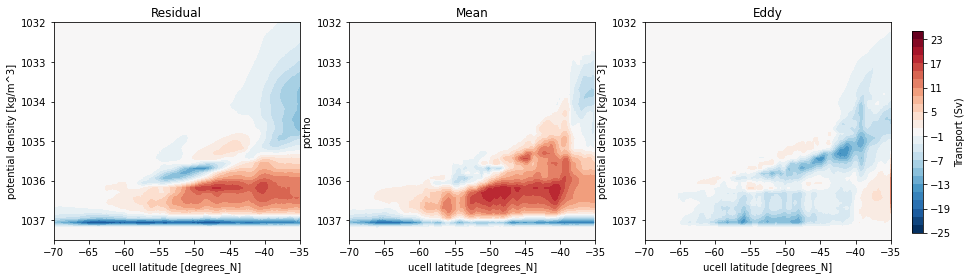

In [22]:
%%time
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
levels = np.arange(-25,26,2)
(psi_avg).plot.contourf(ax = axes[0], x = 'grid_yu_ocean',levels = levels, add_colorbar = False)
(psi_avg_mean).plot.contourf(ax = axes[1], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)
p1 = (psi_avg-psi_avg_mean).plot.contourf(ax = axes[2], x = 'grid_yu_ocean', levels = levels, add_colorbar = False)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Transport (Sv)')

axes[0].set_ylim(1037.5,1032)
axes[1].set_ylim(1037.5,1032)
axes[2].set_ylim(1037.5,1032)
axes[0].set_xlim(-70,-35)
axes[1].set_xlim(-70,-35)
axes[2].set_xlim(-70,-35)

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')

# Method 2: Bin ty_trans (mean Eulerian overturning) into rho bins

This uses the method of Lee et al. (2007) [Lee, M., Nurser, A., Coward, A., and De Cuevas, B. (2007). Eddy advective and diffusive
transports of heat and salt in the Southern Ocean. Journal of Physical Oceanography,
37(5):1376–1393.]

The method is described as follows. Firstly, cells in the model output with a density $\rho$ between two prescribed densities ($\rho_\text{heavy} >\rho> \rho_\text{light}$) are selected. Each cell is assigned a proximity to the lighter density $\rho_\text{light}$, which is the `bin fraction' $f_b = \frac{\rho_\text{heavy}-\rho}{\rho_\text{heavy}-\rho_\text{light}}$. Here, a bin fraction of 1 means the cell density $\rho = \rho_\text{light}$ and $f_b=0$ means $\rho = \rho_\text{heavy}$. The quantity being binned, such as the meridional transport $vh$, is then multiplied by $f_b$ and added to the lighter density $\rho_\text{light}$ bin's meridional transport, followed by the $vh(1-f_b)$ being added to the heavier bin, $\rho_\text{heavy}$. This process is repeated for all sets of consecutive bins, meaning that density bins have input from model output cells with density slightly lower and higher than it. 

In [23]:
# choose bins (in this case, default ty_trans_rho pot_rho_2 bins
rho2_bins = ty_trans_rho.potrho.values
# set up a zero array to be filled in by the algorithm
ty_trans_binned = np.zeros((len(rho2_bins),len(pot_rho_2.yt_ocean),len(pot_rho_2.xt_ocean)))

In [24]:
%%time
# loop over the bins, performing Lee et al. (2007) algorithm
# takes time, faster if ty_trans and pot_rho_2 already loaded
for i in range(len(rho2_bins)-1):
    print(i)
    bin_mask = pot_rho_2.where(pot_rho_2<=rho2_bins[i+1]).where(pot_rho_2>rho2_bins[i])*0+1
    bin_fractions = (rho2_bins[i+1]-pot_rho_2 * bin_mask)/(rho2_bins[i+1]-rho2_bins[i])
    ## bin ty_trans:
    ty_trans_in_lower_bin = (ty_trans * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    ty_trans_binned[i,:,:] += ty_trans_in_lower_bin.fillna(0).values
    del ty_trans_in_lower_bin
    ty_trans_in_upper_bin = (ty_trans * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    ty_trans_binned[i+1,:,:] += ty_trans_in_upper_bin.fillna(0).values
    del ty_trans_in_upper_bin

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
CPU times: user 7min 30s, sys: 5min 53s, total: 13min 23s
Wall time: 12min 30s


In [25]:
# turn np array into xarray
ty_trans_binned_array = xr.DataArray(ty_trans_binned, 
                                               coords = [rho2_bins, pot_rho_2.yt_ocean,pot_rho_2.xt_ocean], 
                                               dims = ['potrho', 'yt_ocean','xt_ocean'], 
                                               name = 'ty_trans_binned')


In [26]:
# interpolate to ty_trans_rho grid
ty_trans_binned_array = ty_trans_binned_array.interp({'yt_ocean':ty_trans_rho.grid_yu_ocean,'xt_ocean':ty_trans_rho.grid_xt_ocean})

In [27]:
# find streamfunction
psi_avg = cumsum_from_bottom(ty_trans_rho.sum('grid_xt_ocean'))/1e6/rho_0
psi_avg_mean_2 = cumsum_from_bottom(ty_trans_binned_array.sum('grid_xt_ocean'))/1e6/rho_0


#### Plot ty_trans_rho, binned ty_trans ("mean" component) and eddy (as a residual)

Text(0.5, 1.0, 'Eddy')

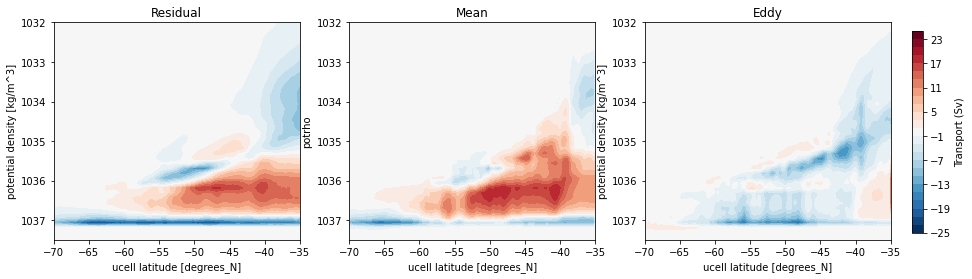

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
levels = np.arange(-25,26,2)
(psi_avg).plot.contourf(ax = axes[0], levels = levels, add_colorbar = False)
(psi_avg_mean_2).plot.contourf(ax = axes[1], levels = levels, add_colorbar = False)
p1 = (psi_avg-psi_avg_mean_2).plot.contourf(ax = axes[2], levels = levels, add_colorbar = False)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Transport (Sv)')

axes[0].set_ylim(1037.5,1032)
axes[1].set_ylim(1037.5,1032)
axes[2].set_ylim(1037.5,1032)
axes[0].set_xlim(-70,-35)
axes[1].set_xlim(-70,-35)
axes[2].set_xlim(-70,-35)

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')

### Both methods yield similar plots of the decomposition of the meridional overturning streamfunction. 

The exact numbers resultant from the transformations will differ, due to the different methods -- they are not exact. When comparing to the model variable `ty_trans_rho`, the `xgcm` method is more appropriate as the online binning is more similar to the `xgcm` binning process than the Lee method. If we were to instead bin the daily transports onto isopycnals and calculate eddy terms directly from the correlation of velocity and thickness fluctuations, the Lee method may be better as the weighted binning onto isopycnals leaves less chance of 'gaps' between density layers. Additionally, it has no issues with partial cells.

The difference between the mean streamfunction between the two methods is presented below.

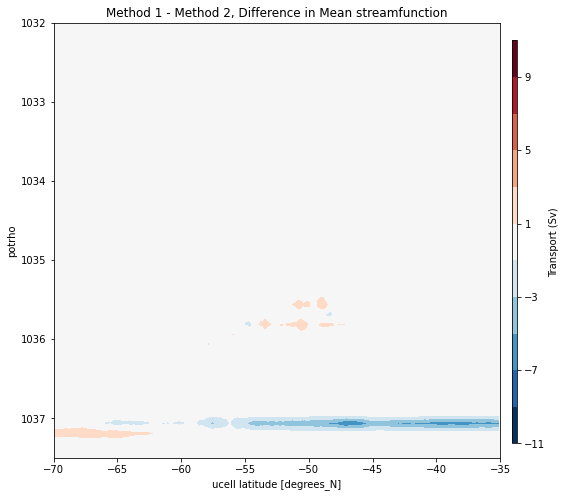

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
levels = np.arange(-11,12,2)
p1 = (psi_avg_mean-psi_avg_mean_2).plot.contourf(ax = ax, y = 'potrho',levels = levels, add_colorbar = False)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Transport (Sv)')

ax.set_ylim(1037.5,1032)
ax.set_xlim(-70,-35)
ax.set_title('Method 1 - Method 2, Difference in Mean streamfunction');

An alternative method to calculate the decomposition of the residual meridional overturning circulation into mean and eddy components is to bin `ty_trans` (or `vhrho_nt`) into density bins using daily data (both density and transport). Then the transport $\overline{vh}$ can be separated into a mean component $\overline{v}\overline{h}$ and an eddy component $\overline{v^\prime h^\prime}$, where the overline is a time average and primed quantities the deviation from the time average. Quantities are calculated within density layers, and $h$ is density layer thickness, calculated by binning `dzt` or `dzu`. This calculation, since it uses daily data, is computationally expensive and is difficult to do efficiently in a jupyter notebook. The resulting streamfunctions are similar, but not identical, and may be more intuitive for isopycnal flows. An example of this can be found at https://github.com/claireyung/Topographic_Hotspots_Upwelling-Paper_Code/blob/main/Figure_Code/Fig5-Overturning.ipynb.